# Donut Fine-tuning

El presente notebook es el proceso de fine-tuning para [DoNut-base](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://huggingface.co/naver-clova-ix/donut-base-finetuned-cord-v2&ved=2ahUKEwjMh4O54vGNAxVsIrkGHQznKskQFnoECBcQAQ&usg=AOvVaw1uKtlO2jgCL6oC_haM4FIB).

In [1]:

pip install datasets transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from transformers import Seq2SeqTrainer, TrainingArguments


2025-06-20 00:23:37.877984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 00:23:37.887012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750389817.896727  160978 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750389817.899667  160978 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750389817.908797  160978 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


In [4]:
import transformers

In [5]:

print(torch.__version__)
print(transformers.__version__)

2.6.0+cu126
4.52.4


# Cargand variables de entorno

In [6]:
from dotenv import load_dotenv
import os

# Try different .env paths
env_path = os.path.join("..",".env")
# env path using os path join
    
print(f"🔍 Trying .env path: {env_path}")

# Load environment variables
found = load_dotenv(env_path)
print(f"✅ .env file {'found' if found else 'not found'}")

# Verify loaded variables
print("\n🔎 Environment variables:")
for var in ["PROCESSED_DATA_DIR", "RAW_DATA_DIR", "CHECKPOINT_DIR"]:
    value = os.getenv(var)
    print(f"{var}: {'✅' if value else '❌'} {value}")

img_dir_train = os.path.join(os.getenv("PROCESSED_DATA_DIR"),'train2014')
img_dir_val = os.path.join(os.getenv("PROCESSED_DATA_DIR"),'val2014')
img_dir_test =  os.path.join(os.getenv("RAW_DATA_DIR"),'test2014')
ann_coco_text = os.path.join("..","data","raw",'cocotext.v2.json')

print(ann_coco_text)

🔍 Trying .env path: ../.env
✅ .env file found

🔎 Environment variables:
PROCESSED_DATA_DIR: ✅ /home/juan/CEIA/vpc3-proyecto/vpc3_proyecto/data/processed
RAW_DATA_DIR: ✅ /home/juan/CEIA/CEIA-ViT/TrabajosPracticos/TP_Final/data/raw
CHECKPOINT_DIR: ✅ /home/juan/CEIA/vpc3-proyecto/vpc3_proyecto/models
../data/raw/cocotext.v2.json


In [1]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base",do_resize=True,size=(768,768),use_fast=True)

model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")



model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size


2025-06-20 14:51:52.543444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 14:51:52.703627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750441912.761821   18656 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750441912.778282   18656 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750441912.913408   18656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [8]:
import json
from torchvision.transforms import Resize
from functools import lru_cache
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import os

class OCRDataset(Dataset):
    def __init__(self, root_dir, processor, max_length=16,annotation_file=None):
        self.root_dir = root_dir
        self.processor = processor
        self.max_length = max_length  # Adjust based on your text length
       
        # Load and clean the dataset
        if not os.path.exists(os.path.join(root_dir, 'labels.csv')):
            # initialize df with empty data with coluymns file_name and text
            self.df = pd.DataFrame(columns=['file_name', 'text'])
        else:
            self.df = pd.read_csv(
                os.path.join(root_dir, 'labels.csv'), 
                header=None, 
                names=['file_name', 'text']
            )
        self.df.dropna(inplace=True)  # Remove NaN
        self.df = self.df[self.df['text'].str.strip().str.len() > 0]  # Remove empty strings
        self.df.reset_index(drop=True, inplace=True)
                # If annotation_file is provided → process it
        if annotation_file:
            print(f"🔍 Loading annotations from {annotation_file} ...")
            with open(annotation_file, "r") as f:
                annotations = json.load(f)

            # Build image_id → best ann mapping
            self.img_id_to_ann = {}
            for ann_id, ann in annotations["anns"].items():
                img_id = ann["image_id"]
                legible = ann.get("legibility", "legible") == "legible"
                bbox = ann["bbox"]
                area = bbox[2] * bbox[3]

                if not legible or area == 0:
                    continue  # skip non-legible or empty boxes

                if img_id not in self.img_id_to_ann:
                    self.img_id_to_ann[img_id] = ann
                else:
                    prev_ann = self.img_id_to_ann[img_id]
                    prev_area = prev_ann["bbox"][2] * prev_ann["bbox"][3]
                    if area > prev_area:
                        self.img_id_to_ann[img_id] = ann

            print(f"✅ Found {len(self.img_id_to_ann)} images with legible annotations.")
            # Map image_id → file_name using your function
            # Filter df to keep only file_names that match the best-annotated image_ids
            # Assuming COCO file_name matches
            img_id_to_filename = { img["id"]: img["file_name"] for img in annotations["imgs"].values() }
# Build dataframe: only keep files that exist in root_dir!
            rows = []
            for img_id, ann in self.img_id_to_ann.items():
                fname = img_id_to_filename.get(img_id)
                text = ann.get("utf8_string", "").strip()
                full_path = os.path.join(root_dir, fname)
                if fname and text and os.path.exists(full_path):
                    rows.append({"file_name": fname, "text": text})

            self.df = pd.DataFrame(rows)
            original_count = len(self.df)
            self.df.dropna(inplace=True)
            self.df.reset_index(drop=True, inplace=True)
            print(f"📄 Filtered dataset from {original_count} to {len(self.df)} images.")

        else:
            self.img_id_to_ann = None  # No annotations provided
    def __len__(self):
        return len(self.df)
    @lru_cache(maxsize=200)  # Cache up to 1000 images in RAM
    def __getitem__(self, idx):
        # Load image and text
        file_name = self.df.iloc[idx]['file_name']
        text = str(self.df.iloc[idx]['text'])
        image = Image.open(os.path.join(self.root_dir, file_name)).convert("RGB")
     # Process image and text
        pixel_values = self.processor(
            image, 
            return_tensors="pt"
        ).pixel_values.squeeze(0)  # Shape: [1, C, H, W] -> [C, H, W]

        # Tokenize text (Donut uses a BART tokenizer)
        labels = self.processor.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()  # Shape: [1, max_length] -> [max_length]

        # Replace padding tokens with -100 (ignored by loss)
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "img_path": os.path.join(self.root_dir, file_name)
        }

In [9]:

# from vpc3_proyecto.model_training.dataset_donut_model import  OCRDataset

# train_dataset = DonutTextDatasetFromCocoTextV2Raw(img_dir_train, ann_coco_text, processor=processor)
# val_dataset = DonutTextDatasetFromCocoTextV2Raw(img_dir_val, ann_coco_text, processor=processor)
# test_dataset = DonutTextDatasetFromCocoTextV2Raw(img_dir_test, ann_coco_text, processor=processor)

train_dataset = OCRDataset(root_dir=img_dir_train, processor=processor)
val_dataset = OCRDataset(root_dir=img_dir_val, processor=processor)


In [10]:
train_dataset.__len__()


9267

In [11]:
val_dataset.__len__()

2694

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.02745098].


Ground truth Text: <s> 01</s>


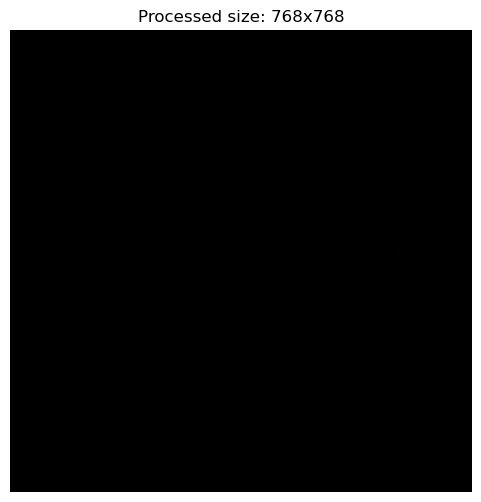

In [12]:
from matplotlib import pyplot as plt
from PIL import Image
sample = train_dataset[0]

first_text = processor.tokenizer.decode(sample["labels"][sample["labels"] != -100])  # Decode the text labels

# If you want to see the actual PIL image before processing:
original_image = Image.open(sample["img_path"]).convert("RGB")

# Display results
print("Ground truth Text:", first_text)
original_image.show() 

# Processed (resized) image
processed = processor(original_image, return_tensors="pt").pixel_values.squeeze(0)  # [C, H, W]
processed_image = processed.permute(1, 2, 0).numpy()  # [H, W, C]

plt.figure(figsize=(6, 6))
plt.imshow(processed_image)
plt.title(f"Processed size: {processed.shape[1]}x{processed.shape[2]}")
plt.axis('off')
plt.show()

In [13]:
train_dataset.__len__()

9267

In [14]:
# test_dataset.__len__()

# Entrenamiento (fine tuning)

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

In [16]:
from transformers import TrainingArguments
# 
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1, 
    fp16=True,
    output_dir="../models/finetuned_donut_weights/cropped_coco",
    logging_steps=50,
    eval_strategy="no",
    save_strategy="epoch",
    num_train_epochs=1,
    report_to="none",
)




In [17]:
from transformers import Trainer
from vpc3_proyecto.model_evaluation.utils import compute_metrics


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:

trainer.train()
# trainer.train(resume_from_checkpoint=True)  # Automatically finds latest checkpoint

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,4.603800
100,4.724500
150,4.490900
200,4.548700
250,4.367700
300,4.423500
350,4.097500
400,4.082500
450,4.188700
500,4.385900


In [20]:

from vpc3_proyecto.model_evaluation.utils import get_last_checkpoint_folder

last_ckpt = get_last_checkpoint_folder(training_args.output_dir)

manually_saved_folder = os.path.join(training_args.output_dir,'checkpoint-10873', "manually-saved")

if  last_ckpt:
    print(f"✅ Último checkpoint: {last_ckpt}")
    processor.save_pretrained(manually_saved_folder)
    trainer.save_model(manually_saved_folder)
    print("✅ Processor guardado en el directorio manual save dentro del checkpoint: "+manually_saved_folder)
else:
    print("❌ No se encontraron checkpoints")



✅ Último checkpoint: ../models/finetuned_donut_weights/checkpoint-50125
✅ Processor guardado en el directorio manual save dentro del checkpoint: ../models/finetuned_donut_weights/checkpoint-10873/manually-saved
